In [64]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from processing.preprocessing import BCIDataProcessor

recording_path_1 = '../recordings/recording_relax2.raw.fif'
recording_path_2 = '../recordings/recording_relax4.raw.fif'
rescale=True
window_size = 2
window_overlap = 0
l_freq, h_freq = 10, 20

processor = BCIDataProcessor(recording_path_1, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale)
data = processor.process()
# Only select relax and focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-4.02240065e-18,  8.71161188e-06,  1.55563382e-05, ...,
          -6.77203084e-06, -9.88590826e-06, -1.19353669e-05],
         [ 3.91731562e-18, -1.18073030e-06, -2.30899909e-06, ...,
          -3.68655040e-06, -7.21914411e-06, -1.02391763e-05],
         [-3.44011844e-18, -1.02645446e-06, -1.89806035e-06, ...,
          -4.65067746e-06, -8.76636566e-06, -1.21261912e-05],
         ...,
         [-4.20784792e-18,  4.55891103e-06,  8.04561931e-06, ...,
          -2.63035331e-06, -4.28498269e-06, -5.33926598e-06],
         [-4.66122231e-18,  2.72149651e-07,  5.90705120e-07, ...,
          -2.11941836e-07, -1.95675362e-06, -3.58720272e-06],
         [-4.25538765e-18, -2.99388056e-06, -5.31535405e-06, ...,
           1.84517520e-06, -2.49475613e-07, -2.59868938e-06]],
 
        [[-1.24759274e-05, -1.13388461e-05, -8.66471490e-06, ...,
          -1.61671272e-05, -1.43169940e-05, -9.66564111e-06],
         [-1.22134249e-05, -1.27679639e-05, -1.17512414e-05, ...,
          -7

In [65]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [66]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((48, 8, 500), (48,), (38, 8, 500), (38,), (10, 8, 500), (10,))

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedKFold
from pyriemann.classification import TSClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define a monte-carlo cross-validation generator (reduce variance):
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use scikit-learn Pipeline with cross_val_score function
# clf = Pipeline([("CSP", CSP(n_components=4, reg=None, log=True, norm_trace=False)), ("LDA", LinearDiscriminantAnalysis())])
# clf = TSClassifier()
# clf = MDM(metric=dict(mean='riemann', distance='riemann'))  # using Riemannian mean and distance
clf = Pipeline([
    ('cov', Covariances()),
    # ('cov', Covariances(estimator='lwf')),
    # ('cov', Covariances(estimator='oas')),
    ('tangent', TangentSpace()),        # project to tangent space (at mean covariance by default)
    ('logreg', LogisticRegression())    # classify in tangent space
])
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Training accuracy: {np.mean(y_pred == y)}")

# scores = cross_val_score(clf, co, y_trainval, cv=cv, n_jobs=1)
# print(f"Classification accuracy: {np.mean(scores)}")

Training accuracy: 0.9583333333333334


In [68]:
# Load the second recording and validate on that
processor = BCIDataProcessor(recording_path_2, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale)
data = processor.process()
# Only select relax/focus
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[ 1.20045744e-18, -8.94684135e-06, -1.58521561e-05, ...,
          -4.40418686e-06, -4.23646545e-06, -3.74148980e-06],
         [-3.75426178e-18, -9.70959648e-06, -1.74079713e-05, ...,
          -2.14611037e-06, -2.66603945e-06, -3.28117965e-06],
         [ 4.98822997e-19, -4.80366370e-06, -8.61327827e-06, ...,
          -3.58952374e-06, -3.15781317e-06, -2.17098265e-06],
         ...,
         [-3.75923810e-18, -1.00034521e-05, -1.78493703e-05, ...,
          -1.81693871e-06, -2.40496106e-06, -3.26442605e-06],
         [-5.36658900e-18, -5.69491493e-06, -1.00989280e-05, ...,
          -8.48367294e-06, -9.01769910e-06, -8.64853450e-06],
         [-1.16418326e-17, -4.06224382e-06, -7.24448029e-06, ...,
          -9.21662339e-06, -9.02053024e-06, -7.80360158e-06]],
 
        [[-3.06688794e-06, -2.37545640e-06, -1.77498722e-06, ...,
          -4.79815963e-06, -5.68657174e-06, -6.03937272e-06],
         [-3.81414880e-06, -4.07995775e-06, -3.90555281e-06, ...,
          -3

In [69]:
# Prepare the data for validation
X_val = np.concatenate(list(data.values()), axis=0)
y_val = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)

# Evaluate the trained model on the validation data
val_score = clf.score(X_val, y_val)
print(f"Validation accuracy: {val_score}")

Validation accuracy: 0.7708333333333334


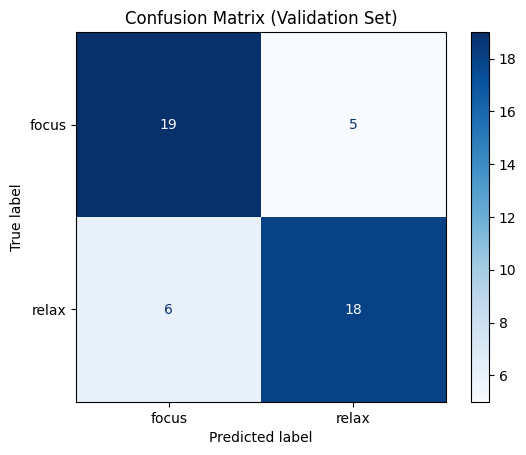

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the validation data
y_val_pred = clf.predict(X_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()